In [6]:
import scipy.io as sio
import numpy as np
import random

def load_and_segment(mat_path, key='Channel_1', seg_len=1024, stride=1024):
    """读取 MAT 文件并按 seg_len 分段"""
    mat = sio.loadmat(mat_path)
    sig = mat[key].squeeze()
    segments = []
    for i in range(0, len(sig) - seg_len + 1, stride):
        segments.append(sig[i:i+seg_len])
    return np.array(segments)

# -------------------------------
# 1. 读取三个文件并分段
# -------------------------------
H_file = r"D:\deskbook\科研\数据集\Ottawa\H-D-1.mat"
I_file = r"D:\deskbook\科研\数据集\Ottawa\I-D-1.mat"
O_file = r"D:\deskbook\科研\数据集\Ottawa\O-D-1.mat"

H_segments = load_and_segment(H_file)
I_segments = load_and_segment(I_file)
O_segments = load_and_segment(O_file)

print("H_A 总样本：", len(H_segments))
print("I_A 总样本：", len(I_segments))
print("O_A 总样本：", len(O_segments))

# -------------------------------
# 2. 每类随机选取 300 个样本
# -------------------------------
def random_select(data, num=300):
    idx = np.random.choice(len(data), num, replace=False)
    return data[idx]

H_sel = random_select(H_segments, 300)
I_sel = random_select(I_segments, 300)
O_sel = random_select(O_segments, 300)

# -------------------------------
# 3. 拼接并创建标签
# -------------------------------
data = np.vstack([H_sel, I_sel, O_sel])
label = np.array([0]*300 + [1]*300 + [2]*300)

print("最终数据 shape:", data.shape)   # (900, 1024)
print("标签 shape:", label.shape)

# -------------------------------
# 4. 保存为 npy
# -------------------------------
np.save("data3.npy", data.astype(np.float32))
np.save("label3.npy", label.astype(np.int64))

print("已生成 data.npy 和 label.npy")


H_A 总样本： 1953
I_A 总样本： 1953
O_A 总样本： 1953
最终数据 shape: (900, 1024)
标签 shape: (900,)
已生成 data.npy 和 label.npy


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
import math
import time
import matplotlib.pyplot as plt
from datetime import datetime

# ==================== Dataset ====================
class BearingDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx].astype(np.float32)
        label = self.labels[idx]
        if self.transform:
            sample = self.transform(sample)
        return torch.from_numpy(sample), torch.tensor(label, dtype=torch.long)

def create_dataloaders(source_idx, target_idx, batch_size=128):

    source_data = np.load(f"data{source_idx}.npy")
    source_labels = np.load(f"label{source_idx}.npy")
    target_data = np.load(f"data{target_idx}.npy")
    target_labels = np.load(f"label{target_idx}.npy")

    print(f"源域工况{source_idx}: {source_data.shape}, 目标域工况{target_idx}: {target_data.shape}")

    # 论文划分方式：630 train, 270 test
    s_train = source_data[:630]
    s_train_label = source_labels[:630]

    t_train = target_data[:630]
    t_test = target_data[630:900]
    t_test_label = target_labels[630:900]

    source_loader = DataLoader(
        BearingDataset(s_train, s_train_label),
        batch_size=batch_size, shuffle=True, drop_last=True)

    target_train_loader = DataLoader(
        BearingDataset(t_train, np.zeros(len(t_train))),
        batch_size=batch_size, shuffle=True, drop_last=True)

    target_test_loader = DataLoader(
        BearingDataset(t_test, t_test_label),
        batch_size=batch_size, shuffle=False)

    print(f"源域训练样本: {len(s_train)}")
    print(f"目标域训练样本: {len(t_train)}")
    print(f"目标域测试样本: {len(t_test)}")

    return source_loader, target_train_loader, target_test_loader

In [29]:
# ==================== Position Encoding ====================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        pe = pe.unsqueeze(1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        return x + self.pe[:x.size(0)]

# ==================== Transformer Encoder Layer ====================
class CustomTransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=512, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=False)
        self.norm1 = nn.LayerNorm(d_model)
        self.drop1 = nn.Dropout(dropout)
        self.ff = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        r, _ = self.attn(x, x, x)
        x = self.norm1(x + self.drop1(r))
        r2 = self.ff(x)
        return self.norm2(x + r2)

# ==================== CNN + Transformer Feature Extractor ====================
class FeatureExtractor(nn.Module):
    def __init__(self, input_length=1024, feature_dim=256):
        super().__init__()

        self.c1 = nn.Conv1d(1, 64, 7, padding=3)
        self.b1 = nn.BatchNorm1d(64)
        self.p1 = nn.MaxPool1d(2)

        self.c2 = nn.Conv1d(64, 128, 5, padding=2)
        self.b2 = nn.BatchNorm1d(128)
        self.p2 = nn.MaxPool1d(2)

        self.c3 = nn.Conv1d(128, 256, 3, padding=1)
        self.b3 = nn.BatchNorm1d(256)
        self.p3 = nn.MaxPool1d(2)

        self.p4 = nn.AdaptiveAvgPool1d(16)

        d_model = 256
        self.pos = PositionalEncoding(d_model)

        enc = CustomTransformerEncoderLayer(d_model, 8, 512, 0.1)
        self.trans = nn.TransformerEncoder(enc, num_layers=2)

        self.proj = nn.Linear(256, feature_dim)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.p1(F.relu(self.b1(self.c1(x))))
        x = self.p2(F.relu(self.b2(self.c2(x))))
        x = self.p3(F.relu(self.b3(self.c3(x))))
        x = self.p4(x)

        x = x.permute(2, 0, 1)
        x = self.pos(x)
        x = self.trans(x)

        x = x.permute(1, 2, 0)
        x = F.adaptive_avg_pool1d(x, 1).squeeze(-1)
        return self.proj(x)

In [30]:

# ==================== Gaussian Mixture CAD ====================
class GaussianMixtureCAD(nn.Module):
    """
    CAD: p_beta(z|w,c) mixture of Gaussians whose means depend on w.
    """
    def __init__(self, num_components=3, latent_dim=1, w_dim=8):
        super().__init__()
        self.K = num_components
        self.D = latent_dim
        self.w_dim = w_dim

        self.base_means = nn.Parameter(torch.randn(self.K, self.D) * 0.01)
        self.base_logvars = nn.Parameter(torch.zeros(self.K, self.D))

        self.w_to_mean = nn.Parameter(torch.randn(self.K, self.w_dim, self.D) * 0.01)

    def forward(self, z, w=None, labels=None):

        B = z.size(0)
        K, D = self.K, self.D

        if w is None:
            mu_eff = self.base_means.unsqueeze(0).expand(B, K, D)
        else:
            shift = torch.einsum('bw,kwd->bkd', w, self.w_to_mean)
            mu_eff = self.base_means.unsqueeze(0) + shift

        var_eff = torch.exp(self.base_logvars).unsqueeze(0).expand(B, K, D)

        z_exp = z.unsqueeze(1)
        term = -0.5 * torch.sum(((z_exp - mu_eff)**2)/var_eff + torch.log(2*math.pi*var_eff), dim=2)
        term = term - term.max(dim=1, keepdim=True).values
        p = F.softmax(term, dim=1)

        if labels is not None:
            return F.one_hot(labels, K).float(), {"mu": mu_eff, "var": var_eff}

        return p, {"mu": mu_eff, "var": var_eff}

# ==================== Domain Alignment Module ====================
class DomainAlignmentModule(nn.Module):
    def __init__(self, feature_dim=256, num_classes=3, z_dim=1, w_dim=8):
        super().__init__()

        self.z_dim = z_dim
        self.w_dim = w_dim
        self.K = num_classes

        # φw recognition net
        self.w_fc = nn.Linear(feature_dim, 128)
        self.w_mu = nn.Linear(128, w_dim)
        self.w_logv = nn.Linear(128, w_dim)

        # φz recognition net
        self.z_fc = nn.Linear(feature_dim, 128)
        self.z_mu = nn.Linear(128, z_dim)
        self.z_logv = nn.Linear(128, z_dim)

        # q(c|x)
        self.comp_net = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

        # CAD
        self.cad = GaussianMixtureCAD(num_components=num_classes, latent_dim=z_dim, w_dim=w_dim)

    def rep(self, mu, logv):
        std = torch.exp(0.5 * logv)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, labels=None):
        h_w = F.relu(self.w_fc(x))
        mu_w, logv_w = self.w_mu(h_w), self.w_logv(h_w)
        w = self.rep(mu_w, logv_w)

        h_z = F.relu(self.z_fc(x))
        mu_z, logv_z = self.z_mu(h_z), self.z_logv(h_z)
        z = self.rep(mu_z, logv_z)

        p_q = F.softmax(self.comp_net(x), dim=1)

        p_beta, info = self.cad(z, w, labels)

        return {
            "w": w, "mu_w": mu_w, "logv_w": logv_w,
            "z": z, "mu_z": mu_z, "logv_z": logv_z,
            "p_q": p_q, "p_beta": p_beta,
            "mu_eff": info["mu"], "var_eff": info["var"]
        }

# ==================== Classifier ====================
class HealthClassifier(nn.Module):
    def __init__(self, in_dim=256, num_classes=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, num_classes)
        )
    def forward(self, x):
        return self.net(x)

# ==================== GMVTDA Model ====================
class GMVTDA(nn.Module):
    def __init__(self, input_length=1024, feature_dim=256, num_classes=3, z_dim=1, w_dim=8):
        super().__init__()
        self.feat = FeatureExtractor(input_length, feature_dim)
        self.align = DomainAlignmentModule(feature_dim, num_classes, z_dim, w_dim)
        self.clf = HealthClassifier(feature_dim, num_classes)

    def forward(self, x, labels=None):
        f = self.feat(x)
        align = self.align(f, labels)
        logit = self.clf(f)
        return {"feat": f, "health": logit, "align": align}

In [31]:
# ==================== GMVTDA Loss ====================
class GMVTDALoss:
    def __init__(self, num_classes=3):
        self.K = num_classes
        self.ce = nn.CrossEntropyLoss()

    def kl_N(self, mu, logv):
        return 0.5 * torch.sum(mu**2 + logv.exp() - logv - 1, dim=1)

    def LW(self, mu_w, logv_w):
        return torch.mean(self.kl_N(mu_w, logv_w))

    def LC(self, p_beta):
        K = p_beta.size(1)
        log_p = torch.log(p_beta + 1e-12)
        u = -math.log(K)
        return torch.mean(torch.sum(p_beta * (log_p - u), dim=1))

    def LGK(self, mu_z, logv_z, p_beta, mu_eff, var_eff):

        B, K, D = mu_eff.shape

        mu_q = mu_z.unsqueeze(1).expand(B, K, D)
        logv_q = logv_z.unsqueeze(1).expand(B, K, D)
        var_q = torch.exp(logv_q)

        kl = 0.5 * torch.sum(
            torch.log(var_eff + 1e-12) - logv_q +
            (var_q + (mu_q - mu_eff)**2) / (var_eff + 1e-12) - 1,
            dim=2
        )

        return torch.mean(torch.sum(p_beta * kl, dim=1))

    def __call__(self, out, source_labels=None):

        align = out["align"]

        if source_labels is not None:
            LH = self.ce(out["health"], source_labels)
        else:
            LH = torch.tensor(0.0, device=out["health"].device)

        L_W = self.LW(align["mu_w"], align["logv_w"])
        L_C = self.LC(align["p_beta"])
        L_GK = self.LGK(align["mu_z"], align["logv_z"], align["p_beta"], align["mu_eff"], align["var_eff"])

        L_DA = L_W + L_C + L_GK

        return LH, L_DA, {"LH": LH.item(), "LW": L_W.item(), "LC": L_C.item(), "LGK": L_GK.item()}

In [32]:
def train_epoch(model, s_loader, t_loader, optim, criterion, device, epoch, total_epochs):

    model.train()
    total = 0

    N = min(len(s_loader), len(t_loader))
    s_it = iter(s_loader)
    t_it = iter(t_loader)

    q = epoch / total_epochs
    alpha = 2 / (1 + math.exp(-10*q)) - 1

    for _ in range(N):
        xs, ys = next(s_it)
        xt, _ = next(t_it)

        xs, ys = xs.to(device), ys.to(device)
        xt = xt.to(device)

        optim.zero_grad()

        # Source
        out_s = model(xs, ys)
        LH_s, LDA_s, _ = criterion(out_s, ys)

        # Target
        out_t = model(xt)
        LH_t, LDA_t, _ = criterion(out_t, None)

        loss = LH_s + alpha*(LDA_s + LDA_t)

        loss.backward()
        optim.step()

        total += loss.item()

    return total / N, alpha

def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            pred = out["health"].argmax(1)
            correct += (pred == y).sum().item()
            total += len(y)
    return correct / total * 100


In [33]:
def main_training(source_domain=0, target_domain=1):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("使用设备:", device)

    batch = 128
    z_dim = 1
    w_dim = 8
    feat_dim = 256
    classes = 3
    epochs = 300
    lr = 1e-4

    s_loader, t_loader, t_test_loader = create_dataloaders(source_domain, target_domain, batch)

    model = GMVTDA(1024, feat_dim, classes, z_dim, w_dim).to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    sched = torch.optim.lr_scheduler.MultiStepLR(optim, [150, 250], gamma=0.1)
    crit = GMVTDALoss(classes)

    print("模型参数数量:", sum(p.numel() for p in model.parameters()))

    for ep in range(epochs):
        loss, alpha = train_epoch(model, s_loader, t_loader, optim, crit, device, ep, epochs)
        sched.step()

        if (ep+1) % 50 == 0 or ep == 0:
            acc_s = evaluate(model, s_loader, device)
            acc_t = evaluate(model, t_test_loader, device)
            print(f"[Epoch {ep+1}/{epochs}] Loss={loss:.4f} Alpha={alpha:.3f} | Source={acc_s:.2f}% Target={acc_t:.2f}%")

    final_s = evaluate(model, s_loader, device)
    final_t = evaluate(model, t_test_loader, device)
    print(f"最终源域准确率: {final_s:.2f}%")
    print(f"最终目标域准确率: {final_t:.2f}%")

    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    torch.save(model.state_dict(), f"gmvtda_{source_domain}to{target_domain}_{ts}.pth")

    return model, final_s, final_t


if __name__ == "__main__":
    print("="*60)
    print("GMVTDA 域适应故障诊断")
    print("="*60)

    model, acc_s, acc_t = main_training(0, 1)


GMVTDA 域适应故障诊断
使用设备: cuda
源域工况0: (900, 1024), 目标域工况1: (900, 1024)
源域训练样本: 630
目标域训练样本: 630
目标域测试样本: 270
模型参数数量: 1403830


AttributeError: 'CustomTransformerEncoderLayer' object has no attribute 'self_attn'

Device: cuda
Model params: 526006
Epoch [1/300] loss=1.0936 alpha=0.0000 src_acc=47.07% tgt_acc=0.00%
Prediction distribution on loader: {1: 270}
Epoch [50/300] loss=0.9015 alpha=0.6733 src_acc=94.73% tgt_acc=0.00%
Prediction distribution on loader: {0: 244, 1: 26}
Epoch [100/300] loss=1.0654 alpha=0.9289 src_acc=99.22% tgt_acc=39.26%
Prediction distribution on loader: {0: 143, 1: 21, 2: 106}
Saved checkpoint: checkpoints\gmvtda_ep100_s0t1.pth
Epoch [150/300] loss=1.0949 alpha=0.9862 src_acc=100.00% tgt_acc=38.52%
Prediction distribution on loader: {0: 150, 1: 16, 2: 104}
Epoch [200/300] loss=1.1020 alpha=0.9974 src_acc=100.00% tgt_acc=37.04%
Prediction distribution on loader: {0: 151, 1: 19, 2: 100}
Saved checkpoint: checkpoints\gmvtda_ep200_s0t1.pth
Epoch [250/300] loss=1.1017 alpha=0.9995 src_acc=100.00% tgt_acc=37.41%
Prediction distribution on loader: {0: 146, 1: 23, 2: 101}
Epoch [300/300] loss=1.1029 alpha=0.9999 src_acc=100.00% tgt_acc=37.04%
Prediction distribution on loader: 

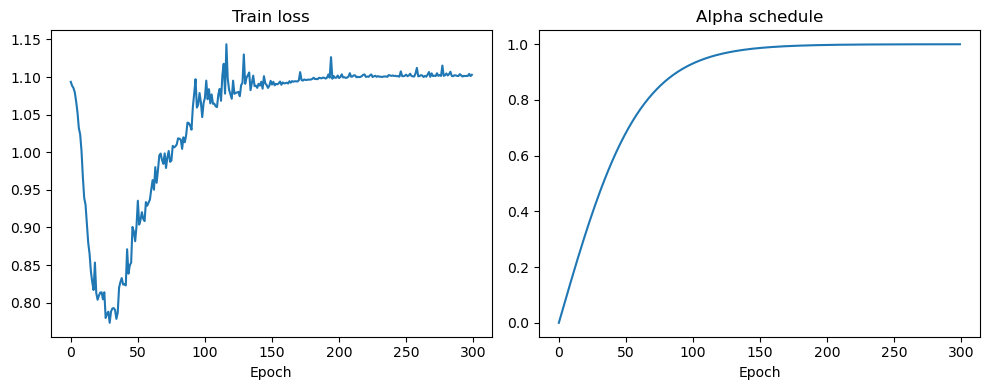

In [37]:


import os
import math
import time
import random
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# -------------------------
# utils
# -------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def normalize_sample(x):
    """逐样本归一化：zero mean, unit std，防止 std=0"""
    x = x.astype(np.float32)
    m = np.mean(x, axis=-1, keepdims=True)
    s = np.std(x, axis=-1, keepdims=True)
    s[s < 1e-6] = 1.0
    return ((x - m) / s).astype(np.float32)

# -------------------------
# Dataset / DataLoader
# -------------------------
class BearingDataset(Dataset):
    def __init__(self, data: np.ndarray, labels: np.ndarray = None, transform=None):
        # data: (N, L) or (N,1,L)
        if data.ndim == 2:
            data = data[:, None, :]
        self.data = data.astype(np.float32)
        if labels is None:
            self.labels = None
        else:
            self.labels = labels.astype(np.int64)
        self.transform = transform

    def __len__(self):
        return len(self.data) if self.labels is None else len(self.labels)

    def __getitem__(self, idx):
        x = self.data[idx]
        if self.transform:
            x = self.transform(x)
        if self.labels is None:
            return torch.from_numpy(x), -1
        else:
            return torch.from_numpy(x), torch.tensor(self.labels[idx], dtype=torch.long)

def build_loaders_from_npy(source_idx, target_idx, batch_domain=128, seg_len=1024, normalize=True):
    sdata = np.load(f"data{source_idx}.npy")  # (900, 1024)
    slabel = np.load(f"label{source_idx}.npy")
    tdata = np.load(f"data{target_idx}.npy")
    tlabel = np.load(f"label{target_idx}.npy")

    if normalize:
        sdata = normalize_sample(sdata)
        tdata = normalize_sample(tdata)

    # per paper: first 630 train, last 270 test
    s_train_x, s_train_y = sdata[:630], slabel[:630]
    t_train_x = tdata[:630]       # unsupervised target train (no labels passed)
    t_test_x, t_test_y = tdata[630:900], tlabel[630:900]

    src_ds = BearingDataset(s_train_x, s_train_y, transform=None)
    tgt_train_ds = BearingDataset(t_train_x, None, transform=None)  # labels none; __getitem__ returns -1 for label
    tgt_test_ds = BearingDataset(t_test_x, t_test_y, transform=None)

    src_loader = DataLoader(src_ds, batch_size=batch_domain, shuffle=True, drop_last=True)
    tgt_train_loader = DataLoader(tgt_train_ds, batch_size=batch_domain, shuffle=True, drop_last=True)
    tgt_test_loader = DataLoader(tgt_test_ds, batch_size=batch_domain, shuffle=False)

    return src_loader, tgt_train_loader, tgt_test_loader

# -------------------------
# Model components
# -------------------------
class PositionalEncodingBatchFirst(nn.Module):
    """Positional encoding that supports batch_first input shape: (B, S, D)"""
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        # store as (1, max_len, d_model) for easy addition to batch_first inputs
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x: (B, S, D)
        L = x.size(1)
        return x + self.pe[:, :L, :]

class FeatureExtractor(nn.Module):
    """1D CNN -> Transformer (batch_first=True) -> global pool -> projection"""
    def __init__(self, input_length=1024, feat_dim=128, nhead=8):
        super().__init__()
        assert feat_dim % nhead == 0, "feat_dim must be divisible by nhead"
        self.conv1 = nn.Conv1d(1, 32, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, feat_dim, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(feat_dim)

        # positional encoding and transformer (batch_first=True)
        self.pos = PositionalEncodingBatchFirst(feat_dim)
        layer = nn.TransformerEncoderLayer(d_model=feat_dim, nhead=nhead, dim_feedforward=512, batch_first=True)
        self.transformer = nn.TransformerEncoder(layer, num_layers=2)

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.proj = nn.Linear(feat_dim, feat_dim)

    def forward(self, x):
        # x: (B, 1, L)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))  # (B, feat_dim, L')
        # prepare for transformer with batch_first
        x_tf = x.permute(0, 2, 1)  # (B, S, D)
        x_tf = self.pos(x_tf)
        x_tf = self.transformer(x_tf)  # (B, S, D)
        x_tf = x_tf.permute(0, 2, 1)  # (B, D, S)
        f = self.global_pool(x_tf).squeeze(-1)  # (B, D)
        return self.proj(f)

# CAD: Gaussian Mixture with w->mu modulation
class GaussianMixtureCAD(nn.Module):
    def __init__(self, num_components=3, latent_dim=1, w_dim=8):
        super().__init__()
        self.K = num_components
        self.D = latent_dim
        self.w_dim = w_dim
        # base params per component
        self.base_means = nn.Parameter(torch.randn(self.K, self.D) * 0.01)
        self.base_logvars = nn.Parameter(torch.zeros(self.K, self.D))
        # mapping from w to mean shifts: (K, w_dim, D)
        self.w_to_mean = nn.Parameter(torch.randn(self.K, self.w_dim, self.D) * 0.01)

    def forward(self, z, w=None, labels=None):
        B = z.size(0)
        K, D = self.K, self.D
        if w is None:
            mu_eff = self.base_means.unsqueeze(0).expand(B, K, D)
        else:
            # w: (B, w_dim) ; w_to_mean: (K, w_dim, D) -> shift: (B, K, D)
            shift = torch.einsum('bw,kwd->bkd', w, self.w_to_mean)
            mu_eff = self.base_means.unsqueeze(0) + shift  # (B,K,D)
        var_eff = torch.exp(self.base_logvars).unsqueeze(0).expand(B, K, D)  # (B,K,D)
        z_exp = z.unsqueeze(1)  # (B,1,D)
        # log p(z|w,c) up to constant
        logp = -0.5 * torch.sum(((z_exp - mu_eff)**2) / (var_eff + 1e-12) + torch.log(2*math.pi*(var_eff + 1e-12)), dim=2)  # (B,K)
        logp = logp - logp.max(dim=1, keepdim=True).values
        p = F.softmax(logp, dim=1)  # (B,K)
        if labels is not None:
            return F.one_hot(labels, self.K).float(), {'mu_eff': mu_eff, 'var_eff': var_eff}
        return p, {'mu_eff': mu_eff, 'var_eff': var_eff}

class DomainAlignmentModule(nn.Module):
    def __init__(self, feat_dim=128, num_classes=3, z_dim=1, w_dim=8):
        super().__init__()
        self.K = num_classes
        self.z_dim = z_dim
        self.w_dim = w_dim
        # phi_w
        self.w_fc = nn.Linear(feat_dim, 128)
        self.w_mu = nn.Linear(128, w_dim)
        self.w_logv = nn.Linear(128, w_dim)
        # phi_z
        self.z_fc = nn.Linear(feat_dim, 128)
        self.z_mu = nn.Linear(128, z_dim)
        self.z_logv = nn.Linear(128, z_dim)
        # q(c|x) optional net
        self.comp_net = nn.Sequential(nn.Linear(feat_dim,128), nn.ReLU(), nn.Linear(128, num_classes))
        # CAD
        self.cad = GaussianMixtureCAD(num_components=num_classes, latent_dim=z_dim, w_dim=w_dim)

    def rep(self, mu, logv):
        std = torch.exp(0.5 * logv)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, labels=None):
        # x: (B, feat_dim)
        h_w = F.relu(self.w_fc(x))
        mu_w = self.w_mu(h_w)
        logv_w = self.w_logv(h_w)
        w = self.rep(mu_w, logv_w)

        h_z = F.relu(self.z_fc(x))
        mu_z = self.z_mu(h_z)
        logv_z = self.z_logv(h_z)
        z = self.rep(mu_z, logv_z)

        comp_q = F.softmax(self.comp_net(x), dim=1)
        p_beta, info = self.cad(z, w, labels)

        # info: mu_eff (B,K,D), var_eff (B,K,D)
        return {
            'w': w, 'mu_w': mu_w, 'logv_w': logv_w,
            'z': z, 'mu_z': mu_z, 'logv_z': logv_z,
            'comp_q': comp_q, 'p_beta': p_beta,
            'mu_eff': info['mu_eff'], 'var_eff': info['var_eff']
        }

class HealthClassifier(nn.Module):
    def __init__(self, feat_dim=128, num_classes=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(feat_dim, 128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )
    def forward(self, x):
        return self.net(x)

class GMVTDA(nn.Module):
    def __init__(self, input_length=1024, feat_dim=128, num_classes=3, z_dim=1, w_dim=8):
        super().__init__()
        self.feat = FeatureExtractor(input_length, feat_dim)
        self.align = DomainAlignmentModule(feat_dim, num_classes, z_dim, w_dim)
        self.clf = HealthClassifier(feat_dim, num_classes)

    def forward(self, x, labels=None):
        # x: (B,1,L)
        feats = self.feat(x)  # (B, feat_dim)
        align_out = self.align(feats, labels)
        logits = self.clf(feats)
        return {'feat': feats, 'health': logits, 'align': align_out}

# -------------------------
# Loss (paper formulas)
# -------------------------
class GMVTDALoss:
    def __init__(self, num_classes=3):
        self.K = num_classes
        self.ce = nn.CrossEntropyLoss()

    def kl_normal(self, mu, logv):
        # per-sample KL to N(0,I) summed across dims
        return 0.5 * torch.sum(mu**2 + logv.exp() - logv - 1, dim=1)  # (B,)

    def L_W(self, mu_w, logv_w):
        return torch.mean(self.kl_normal(mu_w, logv_w))

    def L_C(self, p_beta):
        # KL(p_beta || uniform) = E_p_beta[ log p_beta - log 1/K ]
        K = p_beta.size(1)
        logp = torch.log(p_beta + 1e-12)
        uniform_log = -math.log(K)
        return torch.mean(torch.sum(p_beta * (logp - uniform_log), dim=1))

    def L_GK(self, mu_z, logv_z, p_beta, mu_eff, var_eff):
        # mu_z: (B,D); logv_z: (B,D)
        B = mu_z.size(0)
        D = mu_z.size(1)
        K = p_beta.size(1)
        # expand q params to (B,K,D)
        mu_q = mu_z.unsqueeze(1).expand(B, K, D)
        logv_q = logv_z.unsqueeze(1).expand(B, K, D)
        var_q = torch.exp(logv_q)
        mu_p = mu_eff  # (B,K,D)
        var_p = var_eff  # (B,K,D)
        # KL(q||p) per (B,K)
        kl = 0.5 * torch.sum(torch.log(var_p + 1e-12) - logv_q + (var_q + (mu_q - mu_p)**2) / (var_p + 1e-12) - 1, dim=2)
        # weight by p_beta
        return torch.mean(torch.sum(p_beta * kl, dim=1))

    def __call__(self, model_out, source_labels=None):
        align = model_out['align']
        if source_labels is not None and source_labels.nelement() > 0:
            LH = self.ce(model_out['health'], source_labels)
        else:
            LH = torch.tensor(0.0, device=next(iter(model_out.values())).device)

        Lw = self.L_W(align['mu_w'], align['logv_w'])
        Lc = self.L_C(align['p_beta'])
        Lgk = self.L_GK(align['mu_z'], align['logv_z'], align['p_beta'], align['mu_eff'], align['var_eff'])
        L_DA = Lw + Lc + Lgk
        return LH, L_DA, {'LH': LH.item(), 'Lw': Lw.item(), 'Lc': Lc.item(), 'Lgk': Lgk.item()}

# -------------------------
# training / eval utils
# -------------------------
def debug_pred_distribution(model, loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            p = out['health'].argmax(dim=1).cpu().numpy()
            preds.append(p)
    if len(preds) == 0:
        return {}
    allp = np.concatenate(preds)
    unique, counts = np.unique(allp, return_counts=True)
    dist = dict(zip(unique.tolist(), counts.tolist()))
    print("Prediction distribution on loader:", dist)
    return dist

def train_epoch(model, src_loader, tgt_loader, optimizer, criterion, device, epoch, total_epochs):
    model.train()
    total_batches = min(len(src_loader), len(tgt_loader))
    s_it = iter(src_loader); t_it = iter(tgt_loader)
    q = epoch / float(total_epochs)
    alpha = 2.0 / (1.0 + math.exp(-10.0 * q)) - 1.0
    running_loss = 0.0
    for _ in range(total_batches):
        xs, ys = next(s_it)
        xt, _ = next(t_it)
        xs, ys = xs.to(device), ys.to(device)
        xt = xt.to(device)

        optimizer.zero_grad()
        out_s = model(xs, ys)
        LH_s, LDA_s, _ = criterion(out_s, ys)

        out_t = model(xt)
        LH_t, LDA_t, _ = criterion(out_t, None)

        loss = LH_s + alpha * (LDA_s + LDA_t)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    avg_loss = running_loss / total_batches
    return avg_loss, alpha

def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            pred = out['health'].argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return 100.0 * correct / total if total > 0 else 0.0

# -------------------------
# main training script
# -------------------------
def run_experiment(source_domain=0, target_domain=1, device=None,
                   batch_size=128, feat_dim=128, z_dim=1, w_dim=8,
                   epochs=300, lr=1e-4, save_dir='checkpoints'):
    set_seed(42)
    device = device or (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
    print("Device:", device)

    os.makedirs(save_dir, exist_ok=True)

    src_loader, tgt_train_loader, tgt_test_loader = build_loaders_from_npy(source_domain, target_domain, batch_domain=batch_size)

    model = GMVTDA(input_length=1024, feat_dim=feat_dim, num_classes=3, z_dim=z_dim, w_dim=w_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150, 250], gamma=0.1)
    criterion = GMVTDALoss(num_classes=3)

    print("Model params:", sum(p.numel() for p in model.parameters()))

    history = {'loss': [], 'alpha': [], 'src_acc': [], 'tgt_acc': []}

    for ep in range(epochs):
        loss, alpha = train_epoch(model, src_loader, tgt_train_loader, optimizer, criterion, device, ep, epochs)
        scheduler.step()
        history['loss'].append(loss)
        history['alpha'].append(alpha)

        if (ep + 1) % 50 == 0 or ep == 0:
            src_acc = evaluate(model, src_loader, device)
            tgt_acc = evaluate(model, tgt_test_loader, device)
            history['src_acc'].append(src_acc)
            history['tgt_acc'].append(tgt_acc)
            print(f"Epoch [{ep+1}/{epochs}] loss={loss:.4f} alpha={alpha:.4f} src_acc={src_acc:.2f}% tgt_acc={tgt_acc:.2f}%")
            debug_pred_distribution(model, tgt_test_loader, device)

        # periodic checkpoint
        if (ep + 1) % 100 == 0:
            path = os.path.join(save_dir, f"gmvtda_ep{ep+1}_s{source_domain}t{target_domain}.pth")
            torch.save({'epoch': ep+1, 'model': model.state_dict(), 'optim': optimizer.state_dict(), 'history': history}, path)
            print("Saved checkpoint:", path)

    # final save
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    final_path = os.path.join(save_dir, f"gmvtda_final_s{source_domain}t{target_domain}_{ts}.pth")
    torch.save({'epoch': epochs, 'model': model.state_dict(), 'optim': optimizer.state_dict(), 'history': history}, final_path)
    print("Saved final model:", final_path)

    # final eval
    final_src_acc = evaluate(model, src_loader, device)
    final_tgt_acc = evaluate(model, tgt_test_loader, device)
    print(f"Final Source Acc: {final_src_acc:.2f}%  Final Target Acc: {final_tgt_acc:.2f}%")

    # plot quick curves
    try:
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.plot(history['loss']); plt.title('Train loss'); plt.xlabel('Epoch')
        plt.subplot(1,2,2)
        plt.plot(history['alpha']); plt.title('Alpha schedule'); plt.xlabel('Epoch')
        plt.tight_layout()
        plt.show()
    except Exception:
        pass

    return model, history

# -------------------------
# run if main
# -------------------------
if __name__ == "__main__":
    # Example: train source domain 0 -> target domain 1
    # Ensure files data0.npy,label0.npy ... exist in working dir
    model, history = run_experiment(source_domain=0, target_domain=1, device=None,
                                    batch_size=128, feat_dim=128, z_dim=1, w_dim=8,
                                    epochs=300, lr=1e-4, save_dir='checkpoints')
